Установка зависимостей

In [1]:
!pip install ultralytics pycocotools matplotlib opencv-python
!pip install shapely

  Using cached pycocotools-2.0.8-cp312-cp312-win_amd64.whl.metadata (1.1 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ------------------------------- -------- 0.8/1.0 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 3.7 MB/s eta 0:00:00
Using cached pycocotools-2.0.8-cp312-cp312-win_amd64.whl (83 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)
Using cached torchvision-0.22.0-cp312-cp312-win_amd64.whl (1.7 MB)
Usin

In [12]:
# Скачиваем COCO 2017 (Val) выполнить команды в терминале
# Для Линукса
# Для Linux (все команды выполняются из папки datasets/coco)
# wget http://images.cocodataset.org/zips/train2017.zip
# wget http://images.cocodataset.org/zips/val2017.zip
# wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# unzip train2017.zip -d train2017
# unzip val2017.zip -d val2017
# unzip annotations_trainval2017.zip

# Для Виндовса
# Загрузка файлов
# Invoke-WebRequest -Uri "http://images.cocodataset.org/zips/train2017.zip" -OutFile "train2017.zip"
# Invoke-WebRequest -Uri "http://images.cocodataset.org/zips/val2017.zip" -OutFile "val2017.zip"
# Invoke-WebRequest -Uri "http://images.cocodataset.org/annotations/annotations_trainval2017.zip" -OutFile "annotations_trainval2017.zip"

# Распаковка файлов (PowerShell 5.0+)
# Expand-Archive -Path "train2017.zip" -DestinationPath "train2017"
# Expand-Archive -Path "val2017.zip" -DestinationPath "val2017"
# Expand-Archive -Path "annotations_trainval2017.zip" -DestinationPath "annotations"



In [13]:
import cv2
import numpy as np
from shapely.geometry import Polygon

def apply_fisheye(
    image: np.ndarray,
    k1_range: tuple = (0.1, 0.3),  # Случайный коэффициент из диапазона
    k2_range: tuple = (0.01, 0.1),
    center_var: float = 0.1  # Смещение центра искажения (для реализма)
) -> tuple[np.ndarray, dict]:
    """Применяет fisheye-эффект с вариативными параметрами.
    Возвращает искаженное изображение и параметры (k1, k2, center)."""
    h, w = image.shape[:2]

    # Случайные параметры
    k1 = np.random.uniform(*k1_range)
    k2 = np.random.uniform(*k2_range)
    center = (w/2 + np.random.uniform(-center_var, center_var) * w,
              h/2 + np.random.uniform(-center_var, center_var) * h)

    # Векторизованные вычисления (быстрее в 100+ раз)
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    nx = (x - center[0]) / (w / 2)
    ny = (y - center[1]) / (h / 2)
    r = np.sqrt(nx**2 + ny**2)
    distortion = 1 + k1 * r**2 + k2 * r**4

    map_x = (nx * distortion + 1) * (w / 2)
    map_y = (ny * distortion + 1) * (h / 2)

    # Исправление выхода за границы
    map_x = np.clip(map_x, 0, w - 1).astype(np.float32)
    map_y = np.clip(map_y, 0, h - 1).astype(np.float32)

    fisheye_img = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    params = {'k1': k1, 'k2': k2, 'center': center}
    return fisheye_img, params

def apply_fisheye_to_bbox(bbox: list, img_size: tuple, params: dict) -> list:
    """Пересчет BBox с учетом параметров искажения."""
    x, y, w, h = bbox
    img_w, img_h = img_size
    corners = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]

    distorted_corners = []
    for (px, py) in corners:
        nx = (px - params['center'][0]) / (img_w / 2)
        ny = (py - params['center'][1]) / (img_h / 2)
        r = np.sqrt(nx**2 + ny**2)
        distortion = 1 + params['k1'] * r**2 + params['k2'] * r**4
        dx = nx * distortion * (img_w / 2) + params['center'][0]
        dy = ny * distortion * (img_h / 2) + params['center'][1]
        distorted_corners.append([dx, dy])

    polygon = Polygon(distorted_corners)
    bounds = polygon.bounds
    new_bbox = [
        max(0, bounds[0]),
        max(0, bounds[1]),
        min(img_w, bounds[2]) - max(0, bounds[0]),
        min(img_h, bounds[3]) - max(0, bounds[1])
    ]
    return [round(coord, 2) for coord in new_bbox]

In [32]:
import cv2
import numpy as np
import os
import json
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from shapely.geometry import Polygon

# Настройки
DATA_DIR = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\coco"
IMAGES_DIR = os.path.join(DATA_DIR, "val2017")
ANNOTATIONS_FILE = os.path.join(DATA_DIR, "annotations\instances_val2017.json")
OUTPUT_DIR = r"C:\Users\KosimiK\AI_PROJECTS\fisheye_project\fisheye_coco"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Загрузка COCO
coco = COCO(ANNOTATIONS_FILE)
cat_ids = coco.getCatIds(['person', 'car', 'dog'])
img_ids = coco.getImgIds(catIds=cat_ids)
random_img_id = random.choice(img_ids)
img_info = coco.loadImgs([random_img_id])[0]
annotations = coco.loadAnns(coco.getAnnIds(imgIds=random_img_id))

# Загрузка изображения
image = cv2.imread(os.path.join(IMAGES_DIR, img_info['file_name']))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

<>:15: SyntaxWarning: invalid escape sequence '\i'
<>:15: SyntaxWarning: invalid escape sequence '\i'
C:\Users\KosimiK\AppData\Local\Temp\ipykernel_10108\3495085828.py:15: SyntaxWarning: invalid escape sequence '\i'
  ANNOTATIONS_FILE = os.path.join(DATA_DIR, "annotations\instances_val2017.json")


loading annotations into memory...
Done (t=1.25s)
creating index...
index created!


In [33]:
fisheye_img, params = apply_fisheye(image)  # Используем улучшенную функцию
print("Параметры искажения:", params)

# Пересчет bbox
new_annotations = []
for ann in annotations:
    new_bbox = apply_fisheye_to_bbox(ann['bbox'], (img_info['width'], img_info['height']), params)
    if new_bbox[2] > 5 and new_bbox[3] > 5:  # Отсеиваем слишком мелкие bbox
        ann['bbox'] = new_bbox
        new_annotations.append(ann)

Параметры искажения: {'k1': 0.12442050343735633, 'k2': 0.0776279317050306, 'center': (243.61683165492784, 168.46675311858286)}


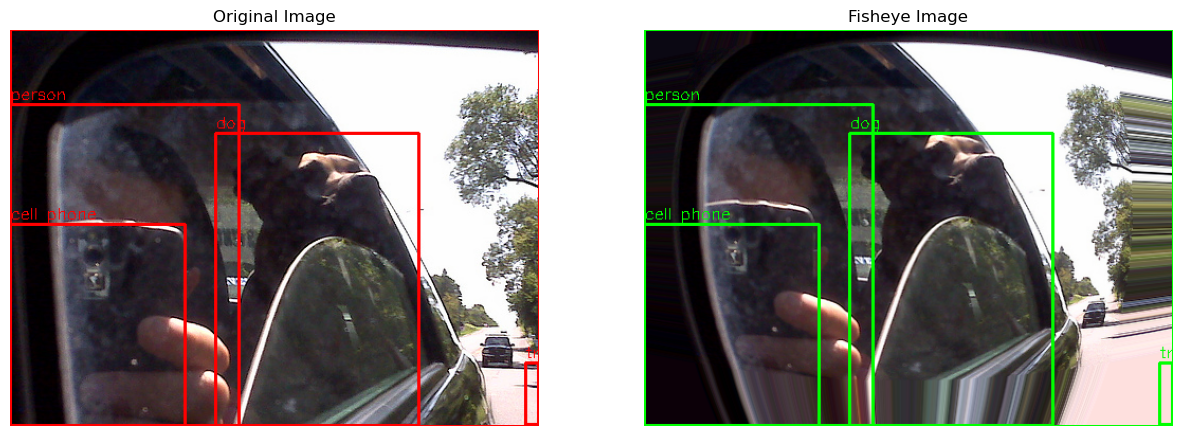

In [34]:
def draw_boxes(img, annotations, color=(0, 255, 0)):
    for ann in annotations:
        x, y, w, h = [int(coord) for coord in ann['bbox']]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{coco.loadCats(ann['category_id'])[0]['name']}",
                    (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(draw_boxes(image.copy(), annotations, (255, 0, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Fisheye Image")
plt.imshow(draw_boxes(fisheye_img.copy(), new_annotations, (0, 255, 0)))
plt.axis('off')
plt.show()

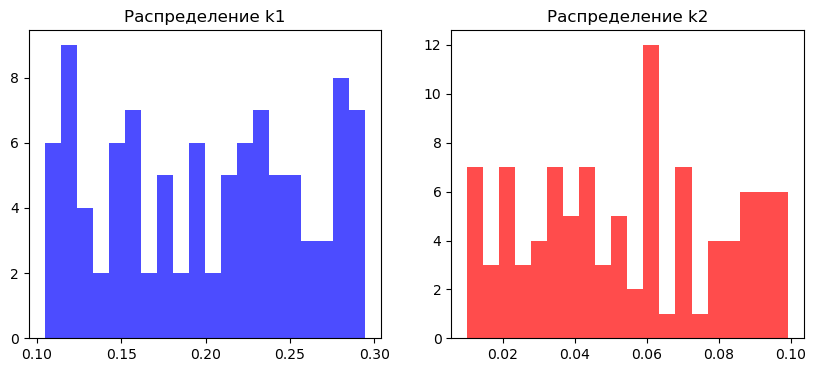

In [35]:
# Генерация 100 случайных искажений и сбор параметров
k1_list, k2_list = [], []
for _ in range(100):
    _, params = apply_fisheye(np.zeros((640, 640, 3)))  # Заглушка
    k1_list.append(params['k1'])
    k2_list.append(params['k2'])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(k1_list, bins=20, color='blue', alpha=0.7)
plt.title("Распределение k1")

plt.subplot(1, 2, 2)
plt.hist(k2_list, bins=20, color='red', alpha=0.7)
plt.title("Распределение k2")
plt.show()

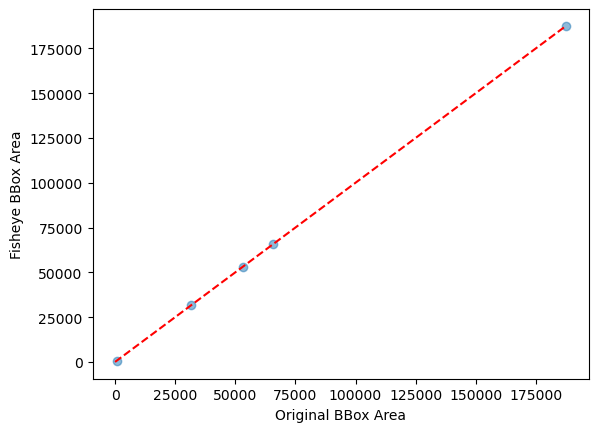

In [36]:
def bbox_area(bbox):
    return bbox[2] * bbox[3]

original_areas = [bbox_area(ann['bbox']) for ann in annotations]
new_areas = [bbox_area(ann['bbox']) for ann in new_annotations]

plt.scatter(original_areas, new_areas, alpha=0.5)
plt.xlabel("Original BBox Area")
plt.ylabel("Fisheye BBox Area")
plt.plot([0, max(original_areas)], [0, max(original_areas)], 'r--')  # Линия y=x
plt.show()

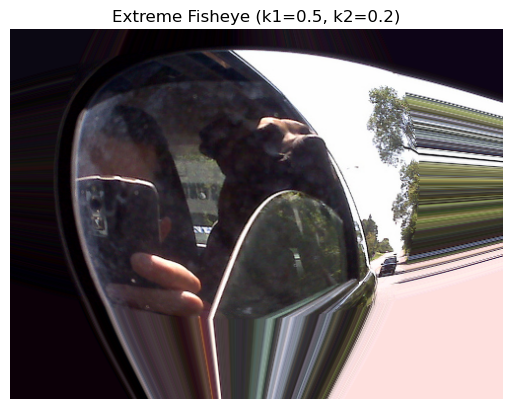

In [37]:
# Максимальное искажение (k1=0.5, k2=0.2)
extreme_img, _ = apply_fisheye(image, k1_range=(0.5, 0.5), k2_range=(0.2, 0.2))
plt.imshow(extreme_img)
plt.title("Extreme Fisheye (k1=0.5, k2=0.2)")
plt.axis('off')
plt.show()

In [38]:
import time

test_image = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
start_time = time.time()
for _ in range(100):
    _ = apply_fisheye(test_image)
print(f"Среднее время: {(time.time() - start_time) / 100:.4f} сек на изображение")

Среднее время: 0.1029 сек на изображение
